<a href="https://colab.research.google.com/github/AndrewCDownie/Classwork/blob/master/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #conv layers
    self.layer1 = nn.Sequential(
        nn.Conv2d( 1,  64,3,stride = 1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( 64,128,3,stride = 1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(128,256,3,stride = 1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(256,256,3,stride = 1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )


    self.layer5 = nn.Sequential(
        nn.Conv2d(256,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )


    self.layer6 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )


    self.layer7 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.layer8 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
      
    )
    #fully connected layers

    self.layer9 = nn.Sequential(
        nn.Linear(512,4096),
        nn.ReLU(),
        nn.Dropout2d(p = 0.5)
    )

    self.layer10 = nn.Sequential(
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout2d(p = 0.5)
    )

    self.layer11 = nn.Sequential(
        nn.Linear(4096,10)
    )

  def forward(self,x):
    x = self.layer1(x)

    x = self.layer2(x)

    x = self.layer3(x)

    x = self.layer4(x)

    x = self.layer5(x)

    x = self.layer6(x)

    x = self.layer7(x)

    x = self.layer8(x)

    x = x.view(-1, 512)
  
    x = self.layer9(x)

    x = self.layer10(x)

    x = self.layer11(x)

    return x

In [53]:
import torchvision
import os
batch_size_train = 256
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("/files/",train=True,download=True,transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32), interpolation=2),torchvision.transforms.ToTensor()])),shuffle = False,batch_size = batch_size_train
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("/files/",train=False,download=True,transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32), interpolation=2),torchvision.transforms.ToTensor()])),batch_size = batch_size_test
)

In [54]:
import torch

if torch.cuda.is_available():
  print("GPU avalible")
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  print("Using CPU")

GPU avalible


In [78]:
import torch.optim as optim
net = Net()
net.cuda()
optimizer = optim.SGD(net.parameters(),lr = 0.001)
#print(net)
loss = nn.CrossEntropyLoss()
i =1
epochs = 5
losses = []
lr = 0.001



train_epoch_accuracies = []
train_batch_accuracies = []
train_epoch_losses = []


test_epoch_accuracies = []
test_epoch_losses =[]


for i in range(epochs):
  train_epoch_correct = 0
  train_epoch_length =0
  train_epoch_loss = 0
  net.train()
  train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("/files/",train=True,download=True,transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32), interpolation=2),torchvision.transforms.ToTensor()])),shuffle = False,batch_size = batch_size_train) 
  print("Starting Epoche",i)
  for b_index,batch in enumerate(train_loader):
    #put data on GPU
    batch_data = batch[0].to(device)
    target_data = batch[1].to(device)

    #run data through model
    output = net(batch_data)

    #comput Gradients
    error_loss = loss(output,target_data)
    train_epoch_loss += error_loss.item()

    net.zero_grad()
    error_loss.backward()
    optimizer.step()
    losses.append(error_loss.item())

    #record training data
    batch_correct = 0
    batch_length = 0
    for out_index,out_row in enumerate(output):
      batch_length +=1
      classication = torch.argmax(F.softmax(out_row))
      if classication.item() == target_data[out_index].item():
        batch_correct += 1
        train_epoch_correct +=1
    train_batch_accuracies.append(batch_correct/batch_length)
    train_epoch_length += batch_length

    if b_index % 100 == 0:
      print("cases complete:",b_index)
      print("last batch accuracy:",batch_correct/batch_length)
  train_epoch_losses.append(train_epoch_loss)
  train_epoch_accuracy = 1.0*train_epoch_correct/train_epoch_length
  train_epoch_accuracies.append(train_epoch_accuracy)
  print("Epoch {} Training, size: {} accuracy: {}, loss: {} ".format(i,train_epoch_length,train_epoch_accuracy,train_epoch_loss))

  print("testing -----")
  net.eval()
  total_correct = 0
  test_loss = 0
  test_case_total = 0
  for t_index, test_case in enumerate(test_loader):
    #put data on gpu
    test_case_data = test_case[0].to(device)
    test_case_target = test_case[1].to(device)

    #run data through model
    output = net(test_case_data)
    test_loss += loss(output,test_case_target).item()  

    #record test information 
    for t_index, output_row in enumerate(output):
      test_case_total += 1
      classication = torch.argmax(F.softmax(output_row))
      #print(F.softmax(out_row))
      #print("----\n",classication.item())
      #print(test_case_target[t_index].item())
      if classication.item() == test_case_target[t_index].item():
        total_correct +=1

  epoch_accuracy = 1.0*total_correct/test_case_total
  test_epoch_accuracies.append(epoch_accuracy)
  test_epoch_losses.append(test_loss)
  print("Epoch {} test, size: {} accuracy: {}, loss: {}".format(i,test_case_total,epoch_accuracy,test_loss))


print(losses)
print(train_epoch_accuracies)

Starting Epoche 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


cases complete: 0
last batch accuracy: 0.1171875
cases complete: 100
last batch accuracy: 0.39453125
cases complete: 200
last batch accuracy: 0.61328125
Epoch 0 Training, size: 60000 accuracy: 0.42905, loss: 462.2192120552063 
testing -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 test, size: 10000 accuracy: 0.8177, loss: 55.419541358947754
Starting Epoche 1
cases complete: 0
last batch accuracy: 0.73828125
cases complete: 100
last batch accuracy: 0.83984375
cases complete: 200
last batch accuracy: 0.8828125
Epoch 1 Training, size: 60000 accuracy: 0.82655, loss: 243.01618120074272 
testing -----
Epoch 1 test, size: 10000 accuracy: 0.935, loss: 20.996990472078323
Starting Epoche 2
cases complete: 0
last batch accuracy: 0.94921875
cases complete: 100
last batch accuracy: 0.93359375
cases complete: 200
last batch accuracy: 0.95703125
Epoch 2 Training, size: 60000 accuracy: 0.9339333333333333, loss: 106.37117451429367 
testing -----
Epoch 2 test, size: 10000 accuracy: 0.9606, loss: 9.253537103533745
Starting Epoche 3
cases complete: 0
last batch accuracy: 0.953125
cases complete: 100
last batch accuracy: 0.95703125
cases complete: 200
last batch accuracy: 0.97265625
Epoch 3 Training, size: 60000 accuracy: 0.95855, loss: 57.975114434957504 
testing -----
Epoc

In [82]:
torch.save(net.state_dict(), "/content/trained_model.pt")

In [ ]:
import matplotlib.pyplot as plt

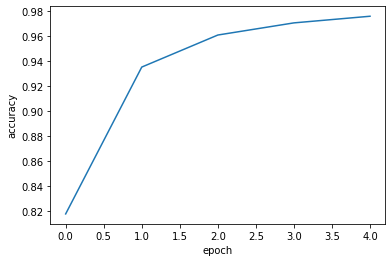

In [91]:
plt.plot(test_epoch_accuracies)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("epoch vs accuracy Test")

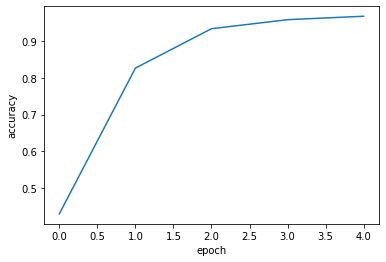

In [92]:
plt.plot(train_epoch_accuracies)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("epoch vs accuracy Train")

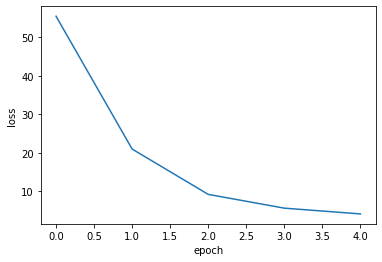

In [93]:
plt.plot(test_epoch_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("epoch vs loss Test")

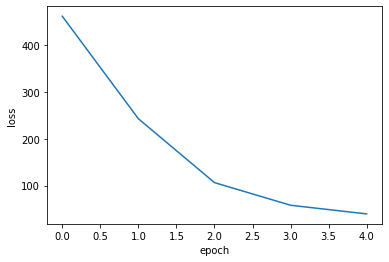

In [94]:
plt.plot(train_epoch_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("epoch vs loss Train")

In [ ]:
#load model with out running previous
net2 = Net()
net2.load_state_dict(torch.load("/content/trained_model.pt"))
